# Install pkgs

**Note:** This is training notebook only. Inference ain't included in .
Anybody who wants to use this notebook for inference purposes is most welcome.

In [ ]:
!pip install git+https://github.com/copick/copick-utils.git matplotlib tqdm copick
!pip install -q "monai-weekly[mlflow]"

  Cloning https://github.com/copick/copick-utils.git to /tmp/pip-req-build-415si454
  Running command git clone --filter=blob:none --quiet https://github.com/copick/copick-utils.git /tmp/pip-req-build-415si454
  Resolved https://github.com/copick/copick-utils.git to commit 79315f3fca71ebfaaff54198b3e08a3bd2ebc63f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 707.0/707.0 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 4.3 MB/s eta 0:00:00
  Created wheel for copick-utils: 

In [ ]:
!pip install zarr

In [ ]:
!pip install copick

In [ ]:
import os
import json
import fileinput
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torchinfo
from torch.utils.data import WeightedRandomSampler, ConcatDataset
import zarr, copick
from glob import glob
from tqdm import tqdm
import shutil
from typing import List, Tuple, Union
from monai.data import DataLoader, Dataset, CacheDataset, decollate_batch
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    Orientationd,
    AsDiscrete,
    RandFlipd,
    RandRotate90d,
    NormalizeIntensityd,
    RandCropByLabelClassesd,
)
from monai.networks.nets import UNet
from monai.losses import DiceLoss, FocalLoss, TverskyLoss
from monai.metrics import DiceMetric, ConfusionMatrixMetric
import mlflow
import mlflow.pytorch

from copick_utils.segmentation import segmentation_from_picks
import copick_utils.writers.write as write
from collections import defaultdict

# 데이터 불러오기

## 기본 데이터

In [ ]:
config_blob = """{
    "name": "czii_cryoet_mlchallenge_2024",
    "description": "2024 CZII CryoET ML Challenge training data.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "apo-ferritin",
            "is_particle": true,
            "pdb_id": "4V1W",
            "label": 1,
            "color": [  0, 117, 220, 128],
            "radius": 60,
            "map_threshold": 0.0418
        },
        {
            "name": "beta-amylase",
            "is_particle": true,
            "pdb_id": "1FA2",
            "label": 2,
            "color": [153,  63,   0, 128],
            "radius": 65,
            "map_threshold": 0.035
        },
        {
            "name": "beta-galactosidase",
            "is_particle": true,
            "pdb_id": "6X1Q",
            "label": 3,
            "color": [ 76,   0,  92, 128],
            "radius": 90,
            "map_threshold": 0.0578
        },
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "6EK0",
            "label": 4,
            "color": [  0,  92,  49, 128],
            "radius": 150,
            "map_threshold": 0.0374
        },
        {
            "name": "thyroglobulin",
            "is_particle": true,
            "pdb_id": "6SCJ",
            "label": 5,
            "color": [ 43, 206,  72, 128],
            "radius": 130,
            "map_threshold": 0.0278
        },
        {
            "name": "virus-like-particle",
            "is_particle": true,
            "pdb_id": "6N4V",
            "label": 6,
            "color": [255, 204, 153, 128],
            "radius": 135,
            "map_threshold": 0.201
        }
    ],

    "overlay_root": "/kaggle/working/overlay_real",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "static_root": "/kaggle/input/czii-cryo-et-object-identification/train/static"
}"""

copick_config_path = "/kaggle/working/copick_real.config" # config 파일을 작성할 위치
output_overlay = "/kaggle/working/overlay_real" # overlay 데이터를 옮겨올 위치

with open(copick_config_path, "w") as f: # 파일 위치를 열어 config 파일 작성
    f.write(config_blob)

# Update the overlay
# Define source and destination directories
source_dir = '/kaggle/input/czii-cryo-et-object-identification/train/overlay' # overlay 데이터가 저장되어 있는 소스디렉토리
destination_dir = '/kaggle/working/overlay_real' # os.paht.join에 사용될 기준 path (여기 밑으로 복사예정)

# Walk through the source directory
for root, dirs, files in os.walk(source_dir): # 데이터가 저장되어 있는 위치에 접근
    # Create corresponding subdirectories in the destination
    relative_path = os.path.relpath(root, source_dir) # relpath: 두번째 파라미터를 기준으로 첫번째 파라미터의 상대경로를 리턴.
    target_dir = os.path.join(destination_dir, relative_path)
    os.makedirs(target_dir, exist_ok=True)

    # Copy and rename each file
    for file in files:
        if file.startswith("curation_0_"):
            new_filename = file
        else:
            new_filename = f"curation_0_{file}"


        # Define full paths for the source and destination files
        source_file = os.path.join(root, file)
        destination_file = os.path.join(target_dir, new_filename)

        # Copy the file with the new name
        shutil.copy2(source_file, destination_file)
        print(f"Copied {source_file} to {destination_file}")

Copied /kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_86_3/Picks/beta-amylase.json to /kaggle/working/overlay_real/ExperimentRuns/TS_86_3/Picks/curation_0_beta-amylase.json
Copied /kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_86_3/Picks/beta-galactosidase.json to /kaggle/working/overlay_real/ExperimentRuns/TS_86_3/Picks/curation_0_beta-galactosidase.json
Copied /kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_86_3/Picks/apo-ferritin.json to /kaggle/working/overlay_real/ExperimentRuns/TS_86_3/Picks/curation_0_apo-ferritin.json
Copied /kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_86_3/Picks/virus-like-particle.json to /kaggle/working/overlay_real/ExperimentRuns/TS_86_3/Picks/curation_0_virus-like-particle.json
Copied /kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_86_3/Picks/ribosome.json to /kaggle/working/overlay_real/E

In [ ]:
root_real = copick.from_file(copick_config_path)

copick_user_name = "copickUtils"
copick_segmentation_name = "paintedPicks_real"
voxel_size = 10
tomo_type = "denoised"

In [ ]:
target_objects = defaultdict(dict)
for object in root_real.pickable_objects:
    if object.is_particle:
        target_objects[object.name]['label'] = object.label
        target_objects[object.name]['radius'] = object.radius


for run in tqdm(root_real.runs):
    tomo = run.get_voxel_spacing(10)
    tomo = tomo.get_tomogram(tomo_type).numpy()
    target = np.zeros(tomo.shape, dtype=np.uint8)
    for pickable_object in root_real.pickable_objects:
        pick = run.get_picks(object_name=pickable_object.name, user_id="curation")
        if len(pick):
            target = segmentation_from_picks.from_picks(pick[0],
                                                        target,
                                                        target_objects[pickable_object.name]['radius'] * 0.8,
                                                        target_objects[pickable_object.name]['label']
                                                        )
    write.segmentation(run, target, copick_user_name, name=copick_segmentation_name)

  0%|          | 0/7 [00:00<?, ?it/s]<ipython-input-7-8162f1ba30dd>:10: DeprecationWarning: get_tomogram is deprecated, use get_tomograms instead. Results may be incomplete
  tomo = tomo.get_tomogram(tomo_type).numpy()
100%|██████████| 7/7 [00:26<00:00,  3.80s/it]


In [ ]:
real_data_dicts = []
for run in tqdm(root_real.runs):
    tomogram = run.get_voxel_spacing(voxel_size).get_tomogram(tomo_type).numpy()
    segmentation = run.get_segmentations(name=copick_segmentation_name, user_id=copick_user_name, voxel_size=voxel_size, is_multilabel=True)[0].numpy()
    real_data_dicts.append({"name": run.name, "image": tomogram, "label": segmentation})

  0%|          | 0/7 [00:00<?, ?it/s]<ipython-input-8-3248e8a49153>:3: DeprecationWarning: get_tomogram is deprecated, use get_tomograms instead. Results may be incomplete
  tomogram = run.get_voxel_spacing(voxel_size).get_tomogram(tomo_type).numpy()
100%|██████████| 7/7 [00:05<00:00,  1.21it/s]


## 추가 데이터

In [ ]:
def ndjson_to_pick(run, particle, src_path, dest_path):
    pick = {}
    pick['pickable_object_name'] = particle
    pick['user_id'] = 'curation'
    pick['session_id'] = '0'
    pick['run_name'] = run
    pick['voxel_spacing'] = None
    pick['unit'] = 'angstrom'
    pick['points'] = []

    lines = fileinput.input(files=[src_path])
    for line in lines:
        nd_point = json.loads(line)
        point = {}
        point['location'] = {}
        point['location']['x'] = 10.012*nd_point['location']['x']
        point['location']['y'] = 10.012*nd_point['location']['y']
        point['location']['z'] = 10.012*nd_point['location']['z']
        point['transformation_'] = [
            [1.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 1.0],
        ]
        point['instance_id'] = 0
        pick['points'].append(point)

    lines.close()

    with open(dest_path, 'w') as f:
        f.write(json.dumps(pick))

In [ ]:
# Load copick config and update static_root for test data
with open(copick_config_path) as f:
    copick_config = json.load(f)
copick_config['static_root'] = ""
copick_config['overlay_root'] = "/kaggle/working/overlay_sim"

# Create a new config file for testing
copick_sim_config_path = '/kaggle/working/copick_sim.config'
with open(copick_sim_config_path, 'w') as outfile:
    json.dump(copick_config, outfile)

In [ ]:
pick_map = {
    'ferritin_complex': 'apo-ferritin',
    'beta_amylase': 'beta-amylase',
    'beta_galactosidase': 'beta-galactosidase',
    'cytosolic_ribosome': 'ribosome',
    'thyroglobulin': 'thyroglobulin',
    'pp7_vlp': 'virus-like-particle',
}
ndjson_files = glob('/kaggle/input/czii10441/10441/TS_*/Reconstructions/VoxelSpacing10.000/Annotations/**/*.ndjson', recursive=True)
for file in ndjson_files:
    run = file.split('/')[5]
    particle = pick_map[file.split('/')[-1].split('-')[0]]
    dest_dir = f'/kaggle/working/overlay_sim/ExperimentRuns/{run}/Picks'
    dest_path = f'{dest_dir}/curation_0_{particle}.json'
    os.makedirs(dest_dir, exist_ok=True)
    ndjson_to_pick(run, particle, file, dest_path)

In [ ]:
root_sim = copick.from_file(copick_sim_config_path)

copick_user_name = "copickUtils"
copick_segmentation_name = "paintedPicks_sim"
voxel_size = 10
tomo_type = "denoised"

In [ ]:
target_objects = defaultdict(dict)
for object in root_sim.pickable_objects:
    if object.is_particle:
        target_objects[object.name]['label'] = object.label
        target_objects[object.name]['radius'] = object.radius


for run in tqdm(root_sim.runs):
    # tomo = run.get_voxel_spacing(10)
    # tomo = tomo.get_tomogram(tomo_type).numpy()
    # target = np.zeros(tomo.shape, dtype=np.uint8)
    target = np.zeros((200, 630, 630), dtype=np.uint8)
    for pickable_object in root_sim.pickable_objects:
        pick = run.get_picks(object_name=pickable_object.name, user_id="curation")
        if len(pick):
            target = segmentation_from_picks.from_picks(pick[0],
                                                        target,
                                                        target_objects[pickable_object.name]['radius'] * 0.8,
                                                        target_objects[pickable_object.name]['label']
                                                        )
    write.segmentation(run, target, copick_user_name, name=copick_segmentation_name)

100%|██████████| 27/27 [00:08<00:00,  3.06it/s]


In [ ]:
!pip install SimpleITK

import SimpleITK as sitk

In [ ]:
def volume_wise_histogram_matching_3d(sim_tomogram, real_tomogram):
    """
    3D 토모그램에 Volume-wise 3D Histogram Matching 적용.

    Args:
        sim_tomogram (np.ndarray): 시뮬레이션 3D 토모그램 (NumPy 배열).
        real_tomogram (np.ndarray): 실제 3D 토모그램 (NumPy 배열, 참조 이미지).

    Returns:
        np.ndarray: Histogram matching이 적용된 3D 토모그램 (NumPy 배열).
    """
    # NumPy 배열을 SimpleITK 이미지 객체로 변환
    sim_tomogram_sitk = sitk.GetImageFromArray(sim_tomogram)
    real_tomogram_sitk = sitk.GetImageFromArray(real_tomogram)

    # HistogramMatchingImageFilter 생성
    histogram_matcher = sitk.HistogramMatchingImageFilter()

    # 필터 파라미터 설정 (선택 사항, 필요에 따라 조정)
    histogram_matcher.SetNumberOfHistogramLevels(1024) # 히스토그램 레벨 수 (기본값: 128)
    histogram_matcher.SetNumberOfMatchPoints(7)      # 매칭 포인트 수 (기본값: 7)

    # Histogram Matching 필터 실행
    matched_tomogram_sitk = histogram_matcher.Execute(sim_tomogram_sitk, real_tomogram_sitk)

    # SimpleITK 이미지 객체를 NumPy 배열로 변환하여 반환
    matched_tomogram_np = sitk.GetArrayFromImage(matched_tomogram_sitk)
    return matched_tomogram_np

In [ ]:
tomograms = glob('/kaggle/input/czii10441/10441/TS_*/Reconstructions/VoxelSpacing10.000/Tomograms/100/TS_*.zarr')
tomogram_map = {}
for t in tomograms:
    tomogram_map[t.split('/')[5]] = t

In [ ]:
from scipy.ndimage import gaussian_filter, median_filter

sim_data_dicts = []
reference_real_tomogram = real_data_dicts[0]['image']

for run in tqdm(root_sim.runs):
    tomogram = np.array(zarr.open(tomogram_map[run.name], mode='r')[0])[:184]
    segmentation = run.get_segmentations(name=copick_segmentation_name, user_id=copick_user_name, voxel_size=voxel_size, is_multilabel=True)[0].numpy()[:184]
    gaussian_filter(tomogram, sigma=1.2, mode='reflect', output=tomogram)
    tomogram = volume_wise_histogram_matching_3d(tomogram, reference_real_tomogram)
    sim_data_dicts.append({"name": run.name, "image": tomogram, "label": segmentation})

100%|██████████| 27/27 [07:30<00:00, 16.68s/it]


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


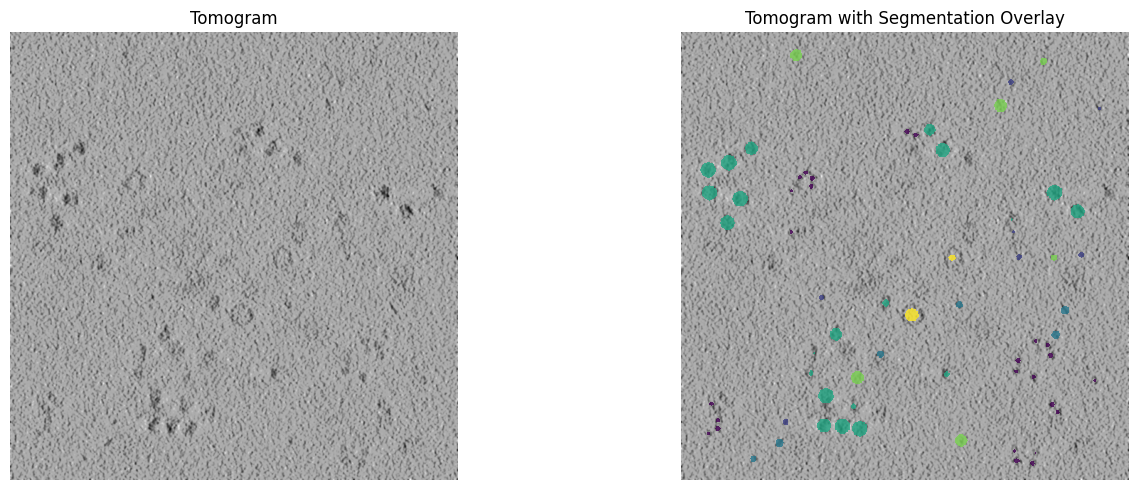

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Tomogram')
plt.imshow(sim_data_dicts[0]['image'][100], cmap='gray') # 토모그램 먼저 그리기
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Tomogram with Segmentation Overlay') # 제목 변경
plt.imshow(sim_data_dicts[0]['image'][100], cmap='gray') # 토모그램을 배경으로 먼저 그리기

# 배경 label을 NaN으로 마스크 처리
background_label = 0 # 배경 label 값 (실제 label 값으로 변경 필요)
masked_label = np.where(sim_data_dicts[0]['label'][100] == background_label, np.nan, sim_data_dicts[0]['label'][100]).astype(float) # NaN으로 변경, float type으로 변환

plt.imshow(masked_label, cmap='viridis', alpha=0.8) # 마스크 처리된 label 데이터 사용
plt.axis('off')

plt.tight_layout()
plt.show()

## 부가 함수 정의

In [ ]:
def extract_3d_patches_minimal_overlap(arrays: List[np.ndarray], patch_size: int) -> Tuple[List[np.ndarray], List[Tuple[int, int, int]]]:
    if not arrays or not isinstance(arrays, list):
        raise ValueError("Input must be a non-empty list of arrays")

    # Verify all arrays have the same shape
    shape = arrays[0].shape
    if not all(arr.shape == shape for arr in arrays):
        raise ValueError("All input arrays must have the same shape")

    if patch_size > min(shape):
        raise ValueError(f"patch_size ({patch_size}) must be smaller than smallest dimension {min(shape)}")

    m, n, l = shape
    patches = []
    coordinates = []

    # Calculate starting positions for each dimension
    x_starts = calculate_patch_starts(m, patch_size)
    y_starts = calculate_patch_starts(n, patch_size)
    z_starts = calculate_patch_starts(l, patch_size)

    # Extract patches from each array
    for arr in arrays:
        for x in x_starts:
            for y in y_starts:
                for z in z_starts:
                    patch = arr[
                        x:x + patch_size,
                        y:y + patch_size,
                        z:z + patch_size
                    ]
                    patches.append(patch)
                    coordinates.append((x, y, z))

    return patches, coordinates

def reconstruct_array(patches: List[np.ndarray],
                     coordinates: List[Tuple[int, int, int]],
                     original_shape: Tuple[int, int, int]) -> np.ndarray:
    reconstructed = np.zeros(original_shape, dtype=np.int64)  # To track overlapping regions

    patch_size = patches[0].shape[0]

    for patch, (x, y, z) in zip(patches, coordinates):
        reconstructed[
            x:x + patch_size,
            y:y + patch_size,
            z:z + patch_size
        ] = patch


    return reconstructed

def calculate_patch_starts(dimension_size: int, patch_size: int) -> List[int]:
    if dimension_size <= patch_size:
        return [0]

    # Calculate number of patches needed
    n_patches = np.ceil(dimension_size / patch_size)

    if n_patches == 1:
        return [0]

    # Calculate overlap
    total_overlap = (n_patches * patch_size - dimension_size) / (n_patches - 1)

    # Generate starting positions
    positions = []
    for i in range(int(n_patches)):
        pos = int(i * (patch_size - total_overlap))
        if pos + patch_size > dimension_size:
            pos = dimension_size - patch_size
        if pos not in positions:  # Avoid duplicates
            positions.append(pos)

    return positions
import pandas as pd

def dict_to_df(coord_dict, experiment_name):
    # Create lists to store data
    all_coords = []
    all_labels = []

    # Process each label and its coordinates
    for label, coords in coord_dict.items():
        all_coords.append(coords)
        all_labels.extend([label] * len(coords))

    # Concatenate all coordinates
    all_coords = np.vstack(all_coords)

    df = pd.DataFrame({
        'experiment': experiment_name,
        'particle_type': all_labels,
        'x': all_coords[:, 0],
        'y': all_coords[:, 1],
        'z': all_coords[:, 2]
    })


    return df

## 데이터로더

In [ ]:
train_files_real, val_files = real_data_dicts[2:7], real_data_dicts[:2]

print([file["name"] for file in val_files])

['TS_5_4', 'TS_69_2']


In [ ]:
my_num_samples = 16
train_batch_size = 1
val_batch_size = 1
num_batch_samples = 30

weight_real = 2.0
weight_sim = 1.0

# Non-random transforms to be cached
non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS")
])

# Random transforms to be applied during training
random_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[96, 96, 96],
        num_classes=8,
        num_samples=my_num_samples
    ),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 2]),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
])

# Create the cached dataset with non-random transforms
#train_ds = CacheDataset(data=train_files, transform=non_random_transforms, cache_rate=0.5)
train_ds_real = Dataset(data=train_files_real, transform=non_random_transforms)
train_ds_real = Dataset(data=train_ds_real, transform=random_transforms)
train_ds_sim = Dataset(data=sim_data_dicts, transform=non_random_transforms)
train_ds_sim = Dataset(data=train_ds_sim, transform=random_transforms)
train_ds = ConcatDataset([train_ds_real, train_ds_sim])

# 가중치 리스트 생성
train_weights = []
for _ in train_files_real: # 실제 데이터셋에 높은 가중치 부여
    train_weights.append(weight_real)
for _ in sim_data_dicts:  # 시뮬레이션 데이터셋에 낮은 가중치 부여
    train_weights.append(weight_sim)

sampler = WeightedRandomSampler(weights=train_weights, num_samples=num_batch_samples, replacement=True)

# DataLoader remains the same
train_loader = DataLoader(
    train_ds,
    batch_size=train_batch_size,
    shuffle=False,
    sampler=sampler,
    num_workers=1,
    pin_memory=torch.cuda.is_available()
)



val_images = [dcts['image'] for dcts in val_files]
val_labels = [dcts['label'] for dcts in val_files]

val_image_patches, _ = extract_3d_patches_minimal_overlap(val_images, 96)
val_label_patches, _ = extract_3d_patches_minimal_overlap(val_labels, 96)

val_patched_data = [{"image": img, "label": lbl} for img, lbl in zip(val_image_patches, val_label_patches)]


#val_ds = CacheDataset(data=val_patched_data, transform=non_random_transforms, cache_rate=0)
val_ds = Dataset(data=val_patched_data, transform=non_random_transforms)

# Create validation DataLoader
val_loader = DataLoader(
    val_ds,
    batch_size=val_batch_size,
    num_workers=1,
    pin_memory=torch.cuda.is_available(),
    shuffle=False,  # Ensure the data order remains consistent
)
#U-net학습을 위한 데이터 전처리과정

## Model setup

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Create UNet, DiceLoss and Adam optimizer
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=len(root_real.pickable_objects)+1,
    channels=(48, 64, 80, 80),
    strides=(2, 2, 1),
    num_res_units=1,
    dropout=0.3
).to(device)

lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr)
#loss_function = DiceLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
loss_function = TverskyLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
dice_metric = DiceMetric(include_background=False, reduction="mean", ignore_empty=True)  # must use onehot for multiclass
recall_metric = ConfusionMatrixMetric(include_background=False, metric_name="recall", reduction="None")
#U-Net아키텍처 정의

cuda


In [ ]:
import gc

post_pred = AsDiscrete(argmax=True, to_onehot=len(root_real.pickable_objects)+1)
post_label = AsDiscrete(to_onehot=len(root_real.pickable_objects)+1)

def train(train_loader, model, loss_function, metrics_function, optimizer, max_epochs=25, patience=5):
    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_no_improve = 0
    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"batch {step}/{num_batch_samples // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
            del inputs, labels, outputs, loss
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        mlflow.log_metric("train_loss", epoch_loss, step=epoch+1)

        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_epoch_loss = 0 # validation epoch loss 초기화
            val_step = 0 # validation step 초기화
            with torch.no_grad():
                for val_data in val_loader:
                    val_step += 1 # validation step 증가
                    val_inputs = val_data["image"].to(device)
                    val_labels = val_data["label"].to(device)
                    val_outputs = model(val_inputs)
                    val_loss = loss_function(val_outputs, val_labels) # validation loss 계산
                    val_epoch_loss += val_loss.item() # validation epoch loss 누적
                    metric_val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    metric_val_labels = [post_label(i) for i in decollate_batch(val_labels)]


                    # compute metric for current iteration
                    metrics_function(y_pred=metric_val_outputs, y=metric_val_labels)

                val_epoch_loss /= val_step # validation epoch loss 평균 계산
                val_loss_values.append(val_epoch_loss) # epoch별 validation loss 값 저장
                print(f"epoch {epoch + 1} average val loss: {val_epoch_loss:.4f}") # validation loss 명확하게 표시

                metrics = metrics_function.aggregate(reduction="mean_batch")
                metric_per_class = ["{:.4g}".format(x) for x in metrics]
                metric = torch.mean(metrics).numpy(force=True)
                mlflow.log_metric("validation metric", metric, step=epoch+1)
                for i,m in enumerate(metrics):
                    mlflow.log_metric(f"validation metric class {i+1}", m, step=epoch+1)
                metrics_function.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    epoch_no_improve = 0
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join('./', "best_metric_model.pth"))
                    print("saved new best metric model")
                else: # metric 개선 없을 시
                    epoch_no_improve += 1 # epoch_no_improve counter 증가
                    if epoch_no_improve >= patience: # patience 횟수 이상 metric 개선 없을 시 Early Stopping
                        print(f"Validation metric did not improve for {patience} epochs. Early stopping triggered.")
                        break # 훈련 루프 종료
                print(
                    f"current epoch: {epoch + 1} current mean recall per class: {', '.join(metric_per_class)}"
                    f"\nbest mean recall: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )
        gc.collect()
        #모델 훈련과 검증

## Training and tracking

In [ ]:
from torchinfo import summary

mlflow.end_run()
mlflow.set_experiment('training 3D U-Net model for the cryoET ML Challenge')
epochs = 100
patience = 3

epoch_loss_values = []
metric_values = []
val_loss_values = []

with mlflow.start_run():
    params = {
        "epochs": epochs,
        "learning_rate": lr,
        "loss_function": loss_function.__class__.__name__,
        "metric_function": recall_metric.__class__.__name__,
        "optimizer": "Adam",
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    with open("model_summary.txt", "w") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("model_summary.txt")

    train(train_loader, model, loss_function, dice_metric, optimizer, max_epochs=epochs, patience=patience)

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model, "model")

2025/01/28 12:48:14 INFO mlflow.tracking.fluent: Experiment with name 'training 3D U-Net model for the cryoET ML Challenge' does not exist. Creating a new experiment.


----------
epoch 1/100


/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.9570
batch 2/30, train_loss: 0.9514
batch 3/30, train_loss: 0.9542
batch 4/30, train_loss: 0.9486
batch 5/30, train_loss: 0.9460
batch 6/30, train_loss: 0.9371
batch 7/30, train_loss: 0.9276
batch 8/30, train_loss: 0.9373
batch 9/30, train_loss: 0.9297
batch 10/30, train_loss: 0.9268
batch 11/30, train_loss: 0.9355
batch 12/30, train_loss: 0.9272
batch 13/30, train_loss: 0.9367
batch 14/30, train_loss: 0.9165
batch 15/30, train_loss: 0.9227
batch 16/30, train_loss: 0.9234
batch 17/30, train_loss: 0.9068
batch 18/30, train_loss: 0.9066
batch 19/30, train_loss: 0.9075
batch 20/30, train_loss: 0.9112
batch 21/30, train_loss: 0.9093
batch 22/30, train_loss: 0.9161
batch 23/30, train_loss: 0.9175
batch 24/30, train_loss: 0.8932
batch 25/30, train_loss: 0.8981
batch 26/30, train_loss: 0.8944
batch 27/30, train_loss: 0.8956
batch 28/30, train_loss: 0.8918
batch 29/30, train_loss: 0.8919
batch 30/30, train_loss: 0.8778
epoch 1 average loss: 0.9198
----------
epoch 2/1

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.8916
batch 2/30, train_loss: 0.9004
batch 3/30, train_loss: 0.8921
batch 4/30, train_loss: 0.8797
batch 5/30, train_loss: 0.8907
batch 6/30, train_loss: 0.8701
batch 7/30, train_loss: 0.8710
batch 8/30, train_loss: 0.8604
batch 9/30, train_loss: 0.8805
batch 10/30, train_loss: 0.8739
batch 11/30, train_loss: 0.8731
batch 12/30, train_loss: 0.8626
batch 13/30, train_loss: 0.8620
batch 14/30, train_loss: 0.8700
batch 15/30, train_loss: 0.8603
batch 16/30, train_loss: 0.8774
batch 17/30, train_loss: 0.8550
batch 18/30, train_loss: 0.8727
batch 19/30, train_loss: 0.8498
batch 20/30, train_loss: 0.8464
batch 21/30, train_loss: 0.8631
batch 22/30, train_loss: 0.8523
batch 23/30, train_loss: 0.8408
batch 24/30, train_loss: 0.8248
batch 25/30, train_loss: 0.8517
batch 26/30, train_loss: 0.8626
batch 27/30, train_loss: 0.8420
batch 28/30, train_loss: 0.8588
batch 29/30, train_loss: 0.8290
batch 30/30, train_loss: 0.8563
epoch 2 average loss: 0.8640
epoch 2 average val 

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.8325
batch 2/30, train_loss: 0.8583
batch 3/30, train_loss: 0.8411
batch 4/30, train_loss: 0.8179
batch 5/30, train_loss: 0.8473
batch 6/30, train_loss: 0.8039
batch 7/30, train_loss: 0.8149
batch 8/30, train_loss: 0.8569
batch 9/30, train_loss: 0.8447
batch 10/30, train_loss: 0.8090
batch 11/30, train_loss: 0.8380
batch 12/30, train_loss: 0.7905
batch 13/30, train_loss: 0.8105
batch 14/30, train_loss: 0.8180
batch 15/30, train_loss: 0.8169
batch 16/30, train_loss: 0.7856
batch 17/30, train_loss: 0.7951
batch 18/30, train_loss: 0.8340
batch 19/30, train_loss: 0.8163
batch 20/30, train_loss: 0.8037
batch 21/30, train_loss: 0.7974
batch 22/30, train_loss: 0.8038
batch 23/30, train_loss: 0.8375
batch 24/30, train_loss: 0.8281
batch 25/30, train_loss: 0.8104
batch 26/30, train_loss: 0.7916
batch 27/30, train_loss: 0.7665
batch 28/30, train_loss: 0.7760
batch 29/30, train_loss: 0.8037
batch 30/30, train_loss: 0.8343
epoch 3 average loss: 0.8161
----------
epoch 4/1

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.8100
batch 2/30, train_loss: 0.8054
batch 3/30, train_loss: 0.7843
batch 4/30, train_loss: 0.8253
batch 5/30, train_loss: 0.7684
batch 6/30, train_loss: 0.7947
batch 7/30, train_loss: 0.7843
batch 8/30, train_loss: 0.7949
batch 9/30, train_loss: 0.7861
batch 10/30, train_loss: 0.7684
batch 11/30, train_loss: 0.7856
batch 12/30, train_loss: 0.7745
batch 13/30, train_loss: 0.8089
batch 14/30, train_loss: 0.7549
batch 15/30, train_loss: 0.7966
batch 16/30, train_loss: 0.7830
batch 17/30, train_loss: 0.7714
batch 18/30, train_loss: 0.7555
batch 19/30, train_loss: 0.8250
batch 20/30, train_loss: 0.7511
batch 21/30, train_loss: 0.8012
batch 22/30, train_loss: 0.7329
batch 23/30, train_loss: 0.7791
batch 24/30, train_loss: 0.8154
batch 25/30, train_loss: 0.7845
batch 26/30, train_loss: 0.7473
batch 27/30, train_loss: 0.7724
batch 28/30, train_loss: 0.7730
batch 29/30, train_loss: 0.8065
batch 30/30, train_loss: 0.7919
epoch 4 average loss: 0.7844
epoch 4 average val 

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.7473
batch 2/30, train_loss: 0.7563
batch 3/30, train_loss: 0.7933
batch 4/30, train_loss: 0.7759
batch 5/30, train_loss: 0.7978
batch 6/30, train_loss: 0.7551
batch 7/30, train_loss: 0.8066
batch 8/30, train_loss: 0.7644
batch 9/30, train_loss: 0.7778
batch 10/30, train_loss: 0.7750
batch 11/30, train_loss: 0.7876
batch 12/30, train_loss: 0.8036
batch 13/30, train_loss: 0.7450
batch 14/30, train_loss: 0.7568
batch 15/30, train_loss: 0.7739
batch 16/30, train_loss: 0.7552
batch 17/30, train_loss: 0.7843
batch 18/30, train_loss: 0.7551
batch 19/30, train_loss: 0.7178
batch 20/30, train_loss: 0.7456
batch 21/30, train_loss: 0.7942
batch 22/30, train_loss: 0.7443
batch 23/30, train_loss: 0.7752
batch 24/30, train_loss: 0.7616
batch 25/30, train_loss: 0.7691
batch 26/30, train_loss: 0.7535
batch 27/30, train_loss: 0.7517
batch 28/30, train_loss: 0.7329
batch 29/30, train_loss: 0.7317
batch 30/30, train_loss: 0.7244
epoch 5 average loss: 0.7638
----------
epoch 6/1

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.7397
batch 2/30, train_loss: 0.7990
batch 3/30, train_loss: 0.7666
batch 4/30, train_loss: 0.7804
batch 5/30, train_loss: 0.7797
batch 6/30, train_loss: 0.7857
batch 7/30, train_loss: 0.7163
batch 8/30, train_loss: 0.7930
batch 9/30, train_loss: 0.7939
batch 10/30, train_loss: 0.7425
batch 11/30, train_loss: 0.7719
batch 12/30, train_loss: 0.7559
batch 13/30, train_loss: 0.7390
batch 14/30, train_loss: 0.7184
batch 15/30, train_loss: 0.7861
batch 16/30, train_loss: 0.7608
batch 17/30, train_loss: 0.8031
batch 18/30, train_loss: 0.7022
batch 19/30, train_loss: 0.7861
batch 20/30, train_loss: 0.7984
batch 21/30, train_loss: 0.7804
batch 22/30, train_loss: 0.7733
batch 23/30, train_loss: 0.7830
batch 24/30, train_loss: 0.7770
batch 25/30, train_loss: 0.7712
batch 26/30, train_loss: 0.7475
batch 27/30, train_loss: 0.7188
batch 28/30, train_loss: 0.7122
batch 29/30, train_loss: 0.7790
batch 30/30, train_loss: 0.7756
epoch 6 average loss: 0.7646
epoch 6 average val 

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.7476
batch 2/30, train_loss: 0.7680
batch 3/30, train_loss: 0.7842
batch 4/30, train_loss: 0.7205
batch 5/30, train_loss: 0.7050
batch 6/30, train_loss: 0.7771
batch 7/30, train_loss: 0.7323
batch 8/30, train_loss: 0.7755
batch 9/30, train_loss: 0.7051
batch 10/30, train_loss: 0.6953
batch 11/30, train_loss: 0.7883
batch 12/30, train_loss: 0.7659
batch 13/30, train_loss: 0.7490
batch 14/30, train_loss: 0.7207
batch 15/30, train_loss: 0.7695
batch 16/30, train_loss: 0.7942
batch 17/30, train_loss: 0.6856
batch 18/30, train_loss: 0.7718
batch 19/30, train_loss: 0.6900
batch 20/30, train_loss: 0.7599
batch 21/30, train_loss: 0.6932
batch 22/30, train_loss: 0.6994
batch 23/30, train_loss: 0.7805
batch 24/30, train_loss: 0.7425
batch 25/30, train_loss: 0.7754
batch 26/30, train_loss: 0.6705
batch 27/30, train_loss: 0.7289
batch 28/30, train_loss: 0.7340
batch 29/30, train_loss: 0.7166
batch 30/30, train_loss: 0.7714
epoch 7 average loss: 0.7406
----------
epoch 8/1

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.7415
batch 2/30, train_loss: 0.7355
batch 3/30, train_loss: 0.7433
batch 4/30, train_loss: 0.7015
batch 5/30, train_loss: 0.7490
batch 6/30, train_loss: 0.7756
batch 7/30, train_loss: 0.7155
batch 8/30, train_loss: 0.7773
batch 9/30, train_loss: 0.7587
batch 10/30, train_loss: 0.7133
batch 11/30, train_loss: 0.7065
batch 12/30, train_loss: 0.7212
batch 13/30, train_loss: 0.7211
batch 14/30, train_loss: 0.7718
batch 15/30, train_loss: 0.7071
batch 16/30, train_loss: 0.7173
batch 17/30, train_loss: 0.6764
batch 18/30, train_loss: 0.7125
batch 19/30, train_loss: 0.7534
batch 20/30, train_loss: 0.7046
batch 21/30, train_loss: 0.7725
batch 22/30, train_loss: 0.7117
batch 23/30, train_loss: 0.7103
batch 24/30, train_loss: 0.6915
batch 25/30, train_loss: 0.7399
batch 26/30, train_loss: 0.6858
batch 27/30, train_loss: 0.6469
batch 28/30, train_loss: 0.7331
batch 29/30, train_loss: 0.7455
batch 30/30, train_loss: 0.7047
epoch 8 average loss: 0.7248
epoch 8 average val 

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.7340
batch 2/30, train_loss: 0.7451
batch 3/30, train_loss: 0.7037
batch 4/30, train_loss: 0.7447
batch 5/30, train_loss: 0.7362
batch 6/30, train_loss: 0.7153
batch 7/30, train_loss: 0.6829
batch 8/30, train_loss: 0.6468
batch 9/30, train_loss: 0.6943
batch 10/30, train_loss: 0.6826
batch 11/30, train_loss: 0.7384
batch 12/30, train_loss: 0.7135
batch 13/30, train_loss: 0.6604
batch 14/30, train_loss: 0.6902
batch 15/30, train_loss: 0.7160
batch 16/30, train_loss: 0.6147
batch 17/30, train_loss: 0.7541
batch 18/30, train_loss: 0.6781
batch 19/30, train_loss: 0.7502
batch 20/30, train_loss: 0.6670
batch 21/30, train_loss: 0.6524
batch 22/30, train_loss: 0.6781
batch 23/30, train_loss: 0.6890
batch 24/30, train_loss: 0.7249
batch 25/30, train_loss: 0.7143
batch 26/30, train_loss: 0.6534
batch 27/30, train_loss: 0.6933
batch 28/30, train_loss: 0.6753
batch 29/30, train_loss: 0.6937
batch 30/30, train_loss: 0.7653
epoch 9 average loss: 0.7003
----------
epoch 10/

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.6088
batch 2/30, train_loss: 0.7749
batch 3/30, train_loss: 0.6660
batch 4/30, train_loss: 0.7167
batch 5/30, train_loss: 0.6680
batch 6/30, train_loss: 0.7297
batch 7/30, train_loss: 0.6821
batch 8/30, train_loss: 0.6612
batch 9/30, train_loss: 0.6622
batch 10/30, train_loss: 0.6155
batch 11/30, train_loss: 0.7194
batch 12/30, train_loss: 0.6723
batch 13/30, train_loss: 0.7340
batch 14/30, train_loss: 0.7172
batch 15/30, train_loss: 0.7008
batch 16/30, train_loss: 0.6347
batch 17/30, train_loss: 0.6721
batch 18/30, train_loss: 0.6201
batch 19/30, train_loss: 0.6744
batch 20/30, train_loss: 0.6966
batch 21/30, train_loss: 0.5903
batch 22/30, train_loss: 0.6231
batch 23/30, train_loss: 0.7487
batch 24/30, train_loss: 0.7328
batch 25/30, train_loss: 0.6650
batch 26/30, train_loss: 0.6977
batch 27/30, train_loss: 0.6287
batch 28/30, train_loss: 0.5520
batch 29/30, train_loss: 0.6115
batch 30/30, train_loss: 0.6591
epoch 10 average loss: 0.6712
epoch 10 average va

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.7106
batch 2/30, train_loss: 0.6132
batch 3/30, train_loss: 0.6234
batch 4/30, train_loss: 0.7746
batch 5/30, train_loss: 0.6474
batch 6/30, train_loss: 0.6397
batch 7/30, train_loss: 0.6622
batch 8/30, train_loss: 0.6732
batch 9/30, train_loss: 0.6732
batch 10/30, train_loss: 0.7020
batch 11/30, train_loss: 0.7454
batch 12/30, train_loss: 0.7252
batch 13/30, train_loss: 0.7640
batch 14/30, train_loss: 0.6972
batch 15/30, train_loss: 0.6643
batch 16/30, train_loss: 0.6897
batch 17/30, train_loss: 0.6642
batch 18/30, train_loss: 0.6923
batch 19/30, train_loss: 0.6884
batch 20/30, train_loss: 0.7378
batch 21/30, train_loss: 0.6206
batch 22/30, train_loss: 0.6613
batch 23/30, train_loss: 0.6635
batch 24/30, train_loss: 0.6535
batch 25/30, train_loss: 0.6096
batch 26/30, train_loss: 0.6100
batch 27/30, train_loss: 0.6434
batch 28/30, train_loss: 0.5924
batch 29/30, train_loss: 0.6272
batch 30/30, train_loss: 0.6438
epoch 11 average loss: 0.6704
----------
epoch 12

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.6428
batch 2/30, train_loss: 0.7182
batch 3/30, train_loss: 0.6111
batch 4/30, train_loss: 0.7050
batch 5/30, train_loss: 0.6324
batch 6/30, train_loss: 0.6219
batch 7/30, train_loss: 0.7627
batch 8/30, train_loss: 0.6576
batch 9/30, train_loss: 0.6232
batch 10/30, train_loss: 0.6146
batch 11/30, train_loss: 0.7524
batch 12/30, train_loss: 0.7787
batch 13/30, train_loss: 0.6130
batch 14/30, train_loss: 0.7136
batch 15/30, train_loss: 0.6407
batch 16/30, train_loss: 0.6485
batch 17/30, train_loss: 0.7403
batch 18/30, train_loss: 0.5997
batch 19/30, train_loss: 0.6713
batch 20/30, train_loss: 0.6714
batch 21/30, train_loss: 0.6493
batch 22/30, train_loss: 0.7001
batch 23/30, train_loss: 0.6681
batch 24/30, train_loss: 0.7345
batch 25/30, train_loss: 0.6248
batch 26/30, train_loss: 0.5876
batch 27/30, train_loss: 0.5462
batch 28/30, train_loss: 0.7079
batch 29/30, train_loss: 0.7336
batch 30/30, train_loss: 0.6926
epoch 12 average loss: 0.6688
epoch 12 average va

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.7141
batch 2/30, train_loss: 0.6297
batch 3/30, train_loss: 0.6423
batch 4/30, train_loss: 0.6549
batch 5/30, train_loss: 0.7620
batch 6/30, train_loss: 0.6721
batch 7/30, train_loss: 0.6045
batch 8/30, train_loss: 0.6126
batch 9/30, train_loss: 0.5930
batch 10/30, train_loss: 0.6817
batch 11/30, train_loss: 0.6975
batch 12/30, train_loss: 0.6913
batch 13/30, train_loss: 0.6647
batch 14/30, train_loss: 0.5990
batch 15/30, train_loss: 0.7137
batch 16/30, train_loss: 0.6284
batch 17/30, train_loss: 0.5610
batch 18/30, train_loss: 0.6074
batch 19/30, train_loss: 0.6096
batch 20/30, train_loss: 0.6082
batch 21/30, train_loss: 0.6410
batch 22/30, train_loss: 0.6342
batch 23/30, train_loss: 0.6277
batch 24/30, train_loss: 0.6362
batch 25/30, train_loss: 0.6290
batch 26/30, train_loss: 0.7157
batch 27/30, train_loss: 0.6265
batch 28/30, train_loss: 0.7535
batch 29/30, train_loss: 0.6572
batch 30/30, train_loss: 0.6871
epoch 13 average loss: 0.6519
----------
epoch 14

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.6908
batch 2/30, train_loss: 0.6379
batch 3/30, train_loss: 0.6438
batch 4/30, train_loss: 0.5836
batch 5/30, train_loss: 0.5932
batch 6/30, train_loss: 0.6482
batch 7/30, train_loss: 0.6319
batch 8/30, train_loss: 0.6134
batch 9/30, train_loss: 0.6820
batch 10/30, train_loss: 0.5972
batch 11/30, train_loss: 0.6454
batch 12/30, train_loss: 0.6029
batch 13/30, train_loss: 0.6176
batch 14/30, train_loss: 0.6253
batch 15/30, train_loss: 0.6170
batch 16/30, train_loss: 0.6126
batch 17/30, train_loss: 0.6652
batch 18/30, train_loss: 0.7190
batch 19/30, train_loss: 0.5886
batch 20/30, train_loss: 0.6548
batch 21/30, train_loss: 0.6988
batch 22/30, train_loss: 0.6316
batch 23/30, train_loss: 0.6400
batch 24/30, train_loss: 0.6553
batch 25/30, train_loss: 0.6942
batch 26/30, train_loss: 0.5712
batch 27/30, train_loss: 0.6244
batch 28/30, train_loss: 0.5868
batch 29/30, train_loss: 0.6267
batch 30/30, train_loss: 0.7483
epoch 14 average loss: 0.6383
epoch 14 average va

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.6219
batch 2/30, train_loss: 0.5820
batch 3/30, train_loss: 0.6149
batch 4/30, train_loss: 0.5900
batch 5/30, train_loss: 0.6441
batch 6/30, train_loss: 0.6185
batch 7/30, train_loss: 0.6794
batch 8/30, train_loss: 0.5540
batch 9/30, train_loss: 0.6006
batch 10/30, train_loss: 0.6083
batch 11/30, train_loss: 0.6667
batch 12/30, train_loss: 0.5805
batch 13/30, train_loss: 0.5872
batch 14/30, train_loss: 0.5720
batch 15/30, train_loss: 0.6414
batch 16/30, train_loss: 0.6179
batch 17/30, train_loss: 0.6207
batch 18/30, train_loss: 0.6749
batch 19/30, train_loss: 0.5964
batch 20/30, train_loss: 0.7345
batch 21/30, train_loss: 0.6459
batch 22/30, train_loss: 0.5948
batch 23/30, train_loss: 0.6666
batch 24/30, train_loss: 0.6497
batch 25/30, train_loss: 0.6754
batch 26/30, train_loss: 0.6644
batch 27/30, train_loss: 0.6663
batch 28/30, train_loss: 0.5818
batch 29/30, train_loss: 0.7011
batch 30/30, train_loss: 0.7231
epoch 15 average loss: 0.6325
----------
epoch 16

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.6856
batch 2/30, train_loss: 0.7007
batch 3/30, train_loss: 0.6131
batch 4/30, train_loss: 0.6840
batch 5/30, train_loss: 0.7151
batch 6/30, train_loss: 0.5942
batch 7/30, train_loss: 0.6734
batch 8/30, train_loss: 0.6703
batch 9/30, train_loss: 0.5984
batch 10/30, train_loss: 0.6691
batch 11/30, train_loss: 0.6273
batch 12/30, train_loss: 0.6875
batch 13/30, train_loss: 0.6439
batch 14/30, train_loss: 0.6133
batch 15/30, train_loss: 0.6899
batch 16/30, train_loss: 0.6241
batch 17/30, train_loss: 0.7271
batch 18/30, train_loss: 0.6451
batch 19/30, train_loss: 0.7043
batch 20/30, train_loss: 0.7275
batch 21/30, train_loss: 0.6883
batch 22/30, train_loss: 0.6069
batch 23/30, train_loss: 0.6481
batch 24/30, train_loss: 0.6242
batch 25/30, train_loss: 0.5988
batch 26/30, train_loss: 0.7248
batch 27/30, train_loss: 0.7315
batch 28/30, train_loss: 0.7445
batch 29/30, train_loss: 0.7175
batch 30/30, train_loss: 0.6679
epoch 16 average loss: 0.6682
epoch 16 average va

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.6683
batch 2/30, train_loss: 0.6138
batch 3/30, train_loss: 0.6977
batch 4/30, train_loss: 0.5691
batch 5/30, train_loss: 0.5789
batch 6/30, train_loss: 0.6177
batch 7/30, train_loss: 0.6181
batch 8/30, train_loss: 0.5986
batch 9/30, train_loss: 0.6438
batch 10/30, train_loss: 0.7234
batch 11/30, train_loss: 0.6729
batch 12/30, train_loss: 0.6461
batch 13/30, train_loss: 0.6465
batch 14/30, train_loss: 0.7428
batch 15/30, train_loss: 0.7172
batch 16/30, train_loss: 0.6413
batch 17/30, train_loss: 0.6907
batch 18/30, train_loss: 0.5744
batch 19/30, train_loss: 0.6845
batch 20/30, train_loss: 0.6451
batch 21/30, train_loss: 0.6902
batch 22/30, train_loss: 0.5901
batch 23/30, train_loss: 0.5961
batch 24/30, train_loss: 0.6425
batch 25/30, train_loss: 0.6686
batch 26/30, train_loss: 0.6570
batch 27/30, train_loss: 0.7093
batch 28/30, train_loss: 0.5685
batch 29/30, train_loss: 0.6998
batch 30/30, train_loss: 0.7086
epoch 17 average loss: 0.6507
----------
epoch 18

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.6612
batch 2/30, train_loss: 0.6011
batch 3/30, train_loss: 0.6182
batch 4/30, train_loss: 0.6180
batch 5/30, train_loss: 0.5998
batch 6/30, train_loss: 0.6080
batch 7/30, train_loss: 0.6778
batch 8/30, train_loss: 0.6598
batch 9/30, train_loss: 0.7182
batch 10/30, train_loss: 0.6131
batch 11/30, train_loss: 0.7001
batch 12/30, train_loss: 0.6757
batch 13/30, train_loss: 0.6275
batch 14/30, train_loss: 0.5876
batch 15/30, train_loss: 0.6322
batch 16/30, train_loss: 0.6129
batch 17/30, train_loss: 0.6770
batch 18/30, train_loss: 0.5607
batch 19/30, train_loss: 0.7274
batch 20/30, train_loss: 0.5827
batch 21/30, train_loss: 0.6291
batch 22/30, train_loss: 0.5642
batch 23/30, train_loss: 0.5304
batch 24/30, train_loss: 0.6923
batch 25/30, train_loss: 0.5670
batch 26/30, train_loss: 0.7070
batch 27/30, train_loss: 0.7396
batch 28/30, train_loss: 0.6110
batch 29/30, train_loss: 0.5848
batch 30/30, train_loss: 0.5933
epoch 18 average loss: 0.6326
epoch 18 average va

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.7178
batch 2/30, train_loss: 0.6142
batch 3/30, train_loss: 0.6790
batch 4/30, train_loss: 0.5988
batch 5/30, train_loss: 0.5746
batch 6/30, train_loss: 0.7090
batch 7/30, train_loss: 0.5529
batch 8/30, train_loss: 0.5733
batch 9/30, train_loss: 0.7059
batch 10/30, train_loss: 0.7344
batch 11/30, train_loss: 0.6081
batch 12/30, train_loss: 0.5695
batch 13/30, train_loss: 0.5780
batch 14/30, train_loss: 0.6232
batch 15/30, train_loss: 0.7273
batch 16/30, train_loss: 0.6200
batch 17/30, train_loss: 0.5914
batch 18/30, train_loss: 0.6642
batch 19/30, train_loss: 0.5748
batch 20/30, train_loss: 0.7087
batch 21/30, train_loss: 0.6943
batch 22/30, train_loss: 0.6695
batch 23/30, train_loss: 0.6853
batch 24/30, train_loss: 0.5371
batch 25/30, train_loss: 0.5935
batch 26/30, train_loss: 0.6489
batch 27/30, train_loss: 0.6021
batch 28/30, train_loss: 0.6060
batch 29/30, train_loss: 0.5408
batch 30/30, train_loss: 0.6394
epoch 19 average loss: 0.6314
----------
epoch 20

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.5874
batch 2/30, train_loss: 0.6144
batch 3/30, train_loss: 0.5964
batch 4/30, train_loss: 0.7249
batch 5/30, train_loss: 0.5854
batch 6/30, train_loss: 0.5413
batch 7/30, train_loss: 0.5774
batch 8/30, train_loss: 0.5887
batch 9/30, train_loss: 0.5491
batch 10/30, train_loss: 0.5809
batch 11/30, train_loss: 0.6806
batch 12/30, train_loss: 0.5959
batch 13/30, train_loss: 0.5596
batch 14/30, train_loss: 0.5893
batch 15/30, train_loss: 0.6134
batch 16/30, train_loss: 0.5651
batch 17/30, train_loss: 0.6319
batch 18/30, train_loss: 0.5559
batch 19/30, train_loss: 0.5730
batch 20/30, train_loss: 0.5744
batch 21/30, train_loss: 0.6410
batch 22/30, train_loss: 0.5348
batch 23/30, train_loss: 0.7185
batch 24/30, train_loss: 0.5393
batch 25/30, train_loss: 0.5493
batch 26/30, train_loss: 0.5547
batch 27/30, train_loss: 0.6931
batch 28/30, train_loss: 0.5867
batch 29/30, train_loss: 0.5534
batch 30/30, train_loss: 0.5691
epoch 20 average loss: 0.5942
epoch 20 average va

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.5742
batch 2/30, train_loss: 0.7120
batch 3/30, train_loss: 0.5744
batch 4/30, train_loss: 0.5818
batch 5/30, train_loss: 0.5613
batch 6/30, train_loss: 0.6848
batch 7/30, train_loss: 0.6103
batch 8/30, train_loss: 0.5783
batch 9/30, train_loss: 0.6057
batch 10/30, train_loss: 0.7162
batch 11/30, train_loss: 0.5750
batch 12/30, train_loss: 0.6431
batch 13/30, train_loss: 0.5727
batch 14/30, train_loss: 0.6699
batch 15/30, train_loss: 0.5916
batch 16/30, train_loss: 0.6307
batch 17/30, train_loss: 0.6430
batch 18/30, train_loss: 0.5771
batch 19/30, train_loss: 0.5899
batch 20/30, train_loss: 0.5935
batch 21/30, train_loss: 0.7572
batch 22/30, train_loss: 0.5401
batch 23/30, train_loss: 0.6096
batch 24/30, train_loss: 0.6115
batch 25/30, train_loss: 0.6090
batch 26/30, train_loss: 0.6147
batch 27/30, train_loss: 0.6743
batch 28/30, train_loss: 0.5376
batch 29/30, train_loss: 0.7073
batch 30/30, train_loss: 0.6787
epoch 21 average loss: 0.6208
----------
epoch 22

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.6721
batch 2/30, train_loss: 0.6796
batch 3/30, train_loss: 0.6018
batch 4/30, train_loss: 0.6957
batch 5/30, train_loss: 0.6509
batch 6/30, train_loss: 0.7109
batch 7/30, train_loss: 0.6126
batch 8/30, train_loss: 0.6722
batch 9/30, train_loss: 0.6402
batch 10/30, train_loss: 0.5830
batch 11/30, train_loss: 0.6744
batch 12/30, train_loss: 0.5967
batch 13/30, train_loss: 0.7254
batch 14/30, train_loss: 0.5999
batch 15/30, train_loss: 0.6054
batch 16/30, train_loss: 0.6752
batch 17/30, train_loss: 0.5614
batch 18/30, train_loss: 0.5528
batch 19/30, train_loss: 0.6706
batch 20/30, train_loss: 0.5516
batch 21/30, train_loss: 0.5276
batch 22/30, train_loss: 0.5641
batch 23/30, train_loss: 0.5948
batch 24/30, train_loss: 0.5488
batch 25/30, train_loss: 0.5921
batch 26/30, train_loss: 0.6926
batch 27/30, train_loss: 0.6003
batch 28/30, train_loss: 0.6922
batch 29/30, train_loss: 0.6164
batch 30/30, train_loss: 0.5690
epoch 22 average loss: 0.6243
epoch 22 average va

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.6951
batch 2/30, train_loss: 0.6982
batch 3/30, train_loss: 0.6225
batch 4/30, train_loss: 0.5831
batch 5/30, train_loss: 0.5949
batch 6/30, train_loss: 0.6458
batch 7/30, train_loss: 0.7159
batch 8/30, train_loss: 0.7229
batch 9/30, train_loss: 0.6266
batch 10/30, train_loss: 0.5624
batch 11/30, train_loss: 0.5731
batch 12/30, train_loss: 0.5100
batch 13/30, train_loss: 0.5847
batch 14/30, train_loss: 0.6601
batch 15/30, train_loss: 0.5538
batch 16/30, train_loss: 0.6108
batch 17/30, train_loss: 0.5876
batch 18/30, train_loss: 0.5796
batch 19/30, train_loss: 0.5845
batch 20/30, train_loss: 0.5766
batch 21/30, train_loss: 0.6580
batch 22/30, train_loss: 0.5493
batch 23/30, train_loss: 0.5614
batch 24/30, train_loss: 0.6821
batch 25/30, train_loss: 0.6617
batch 26/30, train_loss: 0.5279
batch 27/30, train_loss: 0.5749
batch 28/30, train_loss: 0.5628
batch 29/30, train_loss: 0.5727
batch 30/30, train_loss: 0.5799
epoch 23 average loss: 0.6073
----------
epoch 24

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.7131
batch 2/30, train_loss: 0.6033
batch 3/30, train_loss: 0.5729
batch 4/30, train_loss: 0.5847
batch 5/30, train_loss: 0.6946
batch 6/30, train_loss: 0.5714
batch 7/30, train_loss: 0.5601
batch 8/30, train_loss: 0.5660
batch 9/30, train_loss: 0.5383
batch 10/30, train_loss: 0.6816
batch 11/30, train_loss: 0.6034
batch 12/30, train_loss: 0.6992
batch 13/30, train_loss: 0.6032
batch 14/30, train_loss: 0.5713
batch 15/30, train_loss: 0.5872
batch 16/30, train_loss: 0.6388
batch 17/30, train_loss: 0.5581
batch 18/30, train_loss: 0.6216
batch 19/30, train_loss: 0.5869
batch 20/30, train_loss: 0.5915
batch 21/30, train_loss: 0.6682
batch 22/30, train_loss: 0.5786
batch 23/30, train_loss: 0.5607
batch 24/30, train_loss: 0.5696
batch 25/30, train_loss: 0.5635
batch 26/30, train_loss: 0.5857
batch 27/30, train_loss: 0.5830
batch 28/30, train_loss: 0.5899
batch 29/30, train_loss: 0.6661
batch 30/30, train_loss: 0.5001
epoch 24 average loss: 0.6004
epoch 24 average va

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.5524
batch 2/30, train_loss: 0.5660
batch 3/30, train_loss: 0.5307
batch 4/30, train_loss: 0.5993
batch 5/30, train_loss: 0.5944
batch 6/30, train_loss: 0.5357
batch 7/30, train_loss: 0.7215
batch 8/30, train_loss: 0.5783
batch 9/30, train_loss: 0.6077
batch 10/30, train_loss: 0.6607
batch 11/30, train_loss: 0.6242
batch 12/30, train_loss: 0.7263
batch 13/30, train_loss: 0.5607
batch 14/30, train_loss: 0.6469
batch 15/30, train_loss: 0.6665
batch 16/30, train_loss: 0.6225
batch 17/30, train_loss: 0.6884
batch 18/30, train_loss: 0.7066
batch 19/30, train_loss: 0.6799
batch 20/30, train_loss: 0.6564
batch 21/30, train_loss: 0.5730
batch 22/30, train_loss: 0.5704
batch 23/30, train_loss: 0.7037
batch 24/30, train_loss: 0.5360
batch 25/30, train_loss: 0.5291
batch 26/30, train_loss: 0.5918
batch 27/30, train_loss: 0.6365
batch 28/30, train_loss: 0.6962
batch 29/30, train_loss: 0.6924
batch 30/30, train_loss: 0.7171
epoch 25 average loss: 0.6257
----------
epoch 26

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.6837
batch 2/30, train_loss: 0.6426
batch 3/30, train_loss: 0.5658
batch 4/30, train_loss: 0.7120
batch 5/30, train_loss: 0.6027
batch 6/30, train_loss: 0.6430
batch 7/30, train_loss: 0.5848
batch 8/30, train_loss: 0.5514
batch 9/30, train_loss: 0.5756
batch 10/30, train_loss: 0.7159
batch 11/30, train_loss: 0.5732
batch 12/30, train_loss: 0.5549
batch 13/30, train_loss: 0.6767
batch 14/30, train_loss: 0.5769
batch 15/30, train_loss: 0.5999
batch 16/30, train_loss: 0.5920
batch 17/30, train_loss: 0.6800
batch 18/30, train_loss: 0.6005
batch 19/30, train_loss: 0.6286
batch 20/30, train_loss: 0.5814
batch 21/30, train_loss: 0.6704
batch 22/30, train_loss: 0.6650
batch 23/30, train_loss: 0.7123
batch 24/30, train_loss: 0.5162
batch 25/30, train_loss: 0.6639
batch 26/30, train_loss: 0.6972
batch 27/30, train_loss: 0.6754
batch 28/30, train_loss: 0.6065
batch 29/30, train_loss: 0.6191
batch 30/30, train_loss: 0.6864
epoch 26 average loss: 0.6285
epoch 26 average va

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.7010
batch 2/30, train_loss: 0.6849
batch 3/30, train_loss: 0.5962
batch 4/30, train_loss: 0.5863
batch 5/30, train_loss: 0.5817
batch 6/30, train_loss: 0.6199
batch 7/30, train_loss: 0.6814
batch 8/30, train_loss: 0.6855
batch 9/30, train_loss: 0.5502
batch 10/30, train_loss: 0.5502
batch 11/30, train_loss: 0.6482
batch 12/30, train_loss: 0.6231
batch 13/30, train_loss: 0.6516
batch 14/30, train_loss: 0.5674
batch 15/30, train_loss: 0.5683
batch 16/30, train_loss: 0.6019
batch 17/30, train_loss: 0.6277
batch 18/30, train_loss: 0.5739
batch 19/30, train_loss: 0.7181
batch 20/30, train_loss: 0.5786
batch 21/30, train_loss: 0.6163
batch 22/30, train_loss: 0.5493
batch 23/30, train_loss: 0.5507
batch 24/30, train_loss: 0.7452
batch 25/30, train_loss: 0.5500
batch 26/30, train_loss: 0.6809
batch 27/30, train_loss: 0.6736
batch 28/30, train_loss: 0.5541
batch 29/30, train_loss: 0.5499
batch 30/30, train_loss: 0.5905
epoch 27 average loss: 0.6152
----------
epoch 28

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.5723
batch 2/30, train_loss: 0.6607
batch 3/30, train_loss: 0.5655
batch 4/30, train_loss: 0.5926
batch 5/30, train_loss: 0.5722
batch 6/30, train_loss: 0.7016
batch 7/30, train_loss: 0.5923
batch 8/30, train_loss: 0.7066
batch 9/30, train_loss: 0.6006
batch 10/30, train_loss: 0.5967
batch 11/30, train_loss: 0.5980
batch 12/30, train_loss: 0.5997
batch 13/30, train_loss: 0.6667
batch 14/30, train_loss: 0.6741
batch 15/30, train_loss: 0.5957
batch 16/30, train_loss: 0.5685
batch 17/30, train_loss: 0.5080
batch 18/30, train_loss: 0.5260
batch 19/30, train_loss: 0.6252
batch 20/30, train_loss: 0.7188
batch 21/30, train_loss: 0.6052
batch 22/30, train_loss: 0.6199
batch 23/30, train_loss: 0.6059
batch 24/30, train_loss: 0.5600
batch 25/30, train_loss: 0.6965
batch 26/30, train_loss: 0.6487
batch 27/30, train_loss: 0.5714
batch 28/30, train_loss: 0.6523
batch 29/30, train_loss: 0.5871
batch 30/30, train_loss: 0.6405
epoch 28 average loss: 0.6143
epoch 28 average va

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.6417
batch 2/30, train_loss: 0.5718
batch 3/30, train_loss: 0.5574
batch 4/30, train_loss: 0.6582
batch 5/30, train_loss: 0.5654
batch 6/30, train_loss: 0.6769
batch 7/30, train_loss: 0.7137
batch 8/30, train_loss: 0.6723
batch 9/30, train_loss: 0.5411
batch 10/30, train_loss: 0.5618
batch 11/30, train_loss: 0.5510
batch 12/30, train_loss: 0.6767
batch 13/30, train_loss: 0.6870
batch 14/30, train_loss: 0.5813
batch 15/30, train_loss: 0.6127
batch 16/30, train_loss: 0.6210
batch 17/30, train_loss: 0.5611
batch 18/30, train_loss: 0.6514
batch 19/30, train_loss: 0.6905
batch 20/30, train_loss: 0.6100
batch 21/30, train_loss: 0.5124
batch 22/30, train_loss: 0.5788
batch 23/30, train_loss: 0.5551
batch 24/30, train_loss: 0.6370
batch 25/30, train_loss: 0.6666
batch 26/30, train_loss: 0.5020
batch 27/30, train_loss: 0.5425
batch 28/30, train_loss: 0.6650
batch 29/30, train_loss: 0.5559
batch 30/30, train_loss: 0.5766
epoch 29 average loss: 0.6065
----------
epoch 30

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.5936
batch 2/30, train_loss: 0.5939
batch 3/30, train_loss: 0.5996
batch 4/30, train_loss: 0.6777
batch 5/30, train_loss: 0.5499
batch 6/30, train_loss: 0.5555
batch 7/30, train_loss: 0.5645
batch 8/30, train_loss: 0.5606
batch 9/30, train_loss: 0.6179
batch 10/30, train_loss: 0.5617
batch 11/30, train_loss: 0.5714
batch 12/30, train_loss: 0.5622
batch 13/30, train_loss: 0.6450
batch 14/30, train_loss: 0.6657
batch 15/30, train_loss: 0.6506
batch 16/30, train_loss: 0.5251
batch 17/30, train_loss: 0.5752
batch 18/30, train_loss: 0.5684
batch 19/30, train_loss: 0.5364
batch 20/30, train_loss: 0.6707
batch 21/30, train_loss: 0.5357
batch 22/30, train_loss: 0.6735
batch 23/30, train_loss: 0.5479
batch 24/30, train_loss: 0.6507
batch 25/30, train_loss: 0.6891
batch 26/30, train_loss: 0.5453
batch 27/30, train_loss: 0.5388
batch 28/30, train_loss: 0.6181
batch 29/30, train_loss: 0.5600
batch 30/30, train_loss: 0.5841
epoch 30 average loss: 0.5930
epoch 30 average va

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.6661
batch 2/30, train_loss: 0.5897
batch 3/30, train_loss: 0.7412
batch 4/30, train_loss: 0.5667
batch 5/30, train_loss: 0.6572
batch 6/30, train_loss: 0.6696
batch 7/30, train_loss: 0.5238
batch 8/30, train_loss: 0.5584
batch 9/30, train_loss: 0.5840
batch 10/30, train_loss: 0.6006
batch 11/30, train_loss: 0.5515
batch 12/30, train_loss: 0.6041
batch 13/30, train_loss: 0.6342
batch 14/30, train_loss: 0.6187
batch 15/30, train_loss: 0.5549
batch 16/30, train_loss: 0.6386
batch 17/30, train_loss: 0.6708
batch 18/30, train_loss: 0.5749
batch 19/30, train_loss: 0.5413
batch 20/30, train_loss: 0.5544
batch 21/30, train_loss: 0.5683
batch 22/30, train_loss: 0.6253
batch 23/30, train_loss: 0.5851
batch 24/30, train_loss: 0.6330
batch 25/30, train_loss: 0.5431
batch 26/30, train_loss: 0.6975
batch 27/30, train_loss: 0.5438
batch 28/30, train_loss: 0.6554
batch 29/30, train_loss: 0.5952
batch 30/30, train_loss: 0.6130
epoch 31 average loss: 0.6053
----------
epoch 32

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.5298
batch 2/30, train_loss: 0.6410
batch 3/30, train_loss: 0.6875
batch 4/30, train_loss: 0.5729
batch 5/30, train_loss: 0.5675
batch 6/30, train_loss: 0.5834
batch 7/30, train_loss: 0.6098
batch 8/30, train_loss: 0.5434
batch 9/30, train_loss: 0.5246
batch 10/30, train_loss: 0.5222
batch 11/30, train_loss: 0.6941
batch 12/30, train_loss: 0.6498
batch 13/30, train_loss: 0.6091
batch 14/30, train_loss: 0.5812
batch 15/30, train_loss: 0.6666
batch 16/30, train_loss: 0.5334
batch 17/30, train_loss: 0.6494
batch 18/30, train_loss: 0.5514
batch 19/30, train_loss: 0.5937
batch 20/30, train_loss: 0.6647
batch 21/30, train_loss: 0.5994
batch 22/30, train_loss: 0.5512
batch 23/30, train_loss: 0.5198
batch 24/30, train_loss: 0.5595
batch 25/30, train_loss: 0.5266
batch 26/30, train_loss: 0.5484
batch 27/30, train_loss: 0.5578
batch 28/30, train_loss: 0.6188
batch 29/30, train_loss: 0.6528
batch 30/30, train_loss: 0.5868
epoch 32 average loss: 0.5899
epoch 32 average va

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.5700
batch 2/30, train_loss: 0.5748
batch 3/30, train_loss: 0.6245
batch 4/30, train_loss: 0.6003
batch 5/30, train_loss: 0.6816
batch 6/30, train_loss: 0.6503
batch 7/30, train_loss: 0.5281
batch 8/30, train_loss: 0.6580
batch 9/30, train_loss: 0.6232
batch 10/30, train_loss: 0.5706
batch 11/30, train_loss: 0.5940
batch 12/30, train_loss: 0.5513
batch 13/30, train_loss: 0.6951
batch 14/30, train_loss: 0.5591
batch 15/30, train_loss: 0.5991
batch 16/30, train_loss: 0.6339
batch 17/30, train_loss: 0.6052
batch 18/30, train_loss: 0.5761
batch 19/30, train_loss: 0.5849
batch 20/30, train_loss: 0.6475
batch 21/30, train_loss: 0.5875
batch 22/30, train_loss: 0.6306
batch 23/30, train_loss: 0.6517
batch 24/30, train_loss: 0.5381
batch 25/30, train_loss: 0.7052
batch 26/30, train_loss: 0.5899
batch 27/30, train_loss: 0.5830
batch 28/30, train_loss: 0.6048
batch 29/30, train_loss: 0.5539
batch 30/30, train_loss: 0.5446
epoch 33 average loss: 0.6039
----------
epoch 34

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.6674
batch 2/30, train_loss: 0.6138
batch 3/30, train_loss: 0.5734
batch 4/30, train_loss: 0.6185
batch 5/30, train_loss: 0.5101
batch 6/30, train_loss: 0.6227
batch 7/30, train_loss: 0.5720
batch 8/30, train_loss: 0.5696
batch 9/30, train_loss: 0.5222
batch 10/30, train_loss: 0.5854
batch 11/30, train_loss: 0.5887
batch 12/30, train_loss: 0.6098
batch 13/30, train_loss: 0.5848
batch 14/30, train_loss: 0.6571
batch 15/30, train_loss: 0.6859
batch 16/30, train_loss: 0.6605
batch 17/30, train_loss: 0.6393
batch 18/30, train_loss: 0.6746
batch 19/30, train_loss: 0.7053
batch 20/30, train_loss: 0.6322
batch 21/30, train_loss: 0.5944
batch 22/30, train_loss: 0.5593
batch 23/30, train_loss: 0.5794
batch 24/30, train_loss: 0.5560
batch 25/30, train_loss: 0.5979
batch 26/30, train_loss: 0.5268
batch 27/30, train_loss: 0.6201
batch 28/30, train_loss: 0.5175
batch 29/30, train_loss: 0.5805
batch 30/30, train_loss: 0.5481
epoch 34 average loss: 0.5991
epoch 34 average va

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.5682
batch 2/30, train_loss: 0.5883
batch 3/30, train_loss: 0.6780
batch 4/30, train_loss: 0.5822
batch 5/30, train_loss: 0.6694
batch 6/30, train_loss: 0.5447
batch 7/30, train_loss: 0.5984
batch 8/30, train_loss: 0.5898
batch 9/30, train_loss: 0.5548
batch 10/30, train_loss: 0.7312
batch 11/30, train_loss: 0.6423
batch 12/30, train_loss: 0.5810
batch 13/30, train_loss: 0.6392
batch 14/30, train_loss: 0.7114
batch 15/30, train_loss: 0.6321
batch 16/30, train_loss: 0.7028
batch 17/30, train_loss: 0.5774
batch 18/30, train_loss: 0.5508
batch 19/30, train_loss: 0.5848
batch 20/30, train_loss: 0.5436
batch 21/30, train_loss: 0.4912
batch 22/30, train_loss: 0.6698
batch 23/30, train_loss: 0.6530
batch 24/30, train_loss: 0.4904
batch 25/30, train_loss: 0.6315
batch 26/30, train_loss: 0.6746
batch 27/30, train_loss: 0.5610
batch 28/30, train_loss: 0.6557
batch 29/30, train_loss: 0.6900
batch 30/30, train_loss: 0.5882
epoch 35 average loss: 0.6125
----------
epoch 36

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.6585
batch 2/30, train_loss: 0.5655
batch 3/30, train_loss: 0.5666
batch 4/30, train_loss: 0.5596
batch 5/30, train_loss: 0.5326
batch 6/30, train_loss: 0.6751
batch 7/30, train_loss: 0.5459
batch 8/30, train_loss: 0.5659
batch 9/30, train_loss: 0.6474
batch 10/30, train_loss: 0.5637
batch 11/30, train_loss: 0.5658
batch 12/30, train_loss: 0.5762
batch 13/30, train_loss: 0.5315
batch 14/30, train_loss: 0.6123
batch 15/30, train_loss: 0.5255
batch 16/30, train_loss: 0.6469
batch 17/30, train_loss: 0.5406
batch 18/30, train_loss: 0.5484
batch 19/30, train_loss: 0.6992
batch 20/30, train_loss: 0.5629
batch 21/30, train_loss: 0.5541
batch 22/30, train_loss: 0.6300
batch 23/30, train_loss: 0.6721
batch 24/30, train_loss: 0.5365
batch 25/30, train_loss: 0.5217
batch 26/30, train_loss: 0.5665
batch 27/30, train_loss: 0.6036
batch 28/30, train_loss: 0.6373
batch 29/30, train_loss: 0.4986
batch 30/30, train_loss: 0.5632
epoch 36 average loss: 0.5825
epoch 36 average va

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.5384
batch 2/30, train_loss: 0.6479
batch 3/30, train_loss: 0.6042
batch 4/30, train_loss: 0.5998
batch 5/30, train_loss: 0.5931
batch 6/30, train_loss: 0.5349
batch 7/30, train_loss: 0.6658
batch 8/30, train_loss: 0.6441
batch 9/30, train_loss: 0.6292
batch 10/30, train_loss: 0.6030
batch 11/30, train_loss: 0.6184
batch 12/30, train_loss: 0.6124
batch 13/30, train_loss: 0.5781
batch 14/30, train_loss: 0.6320
batch 15/30, train_loss: 0.7030
batch 16/30, train_loss: 0.5118
batch 17/30, train_loss: 0.5398
batch 18/30, train_loss: 0.6643
batch 19/30, train_loss: 0.6352
batch 20/30, train_loss: 0.4819
batch 21/30, train_loss: 0.6641
batch 22/30, train_loss: 0.6082
batch 23/30, train_loss: 0.6217
batch 24/30, train_loss: 0.5747
batch 25/30, train_loss: 0.5212
batch 26/30, train_loss: 0.5728
batch 27/30, train_loss: 0.5398
batch 28/30, train_loss: 0.5631
batch 29/30, train_loss: 0.6987
batch 30/30, train_loss: 0.5236
epoch 37 average loss: 0.5975
----------
epoch 38

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.5952
batch 2/30, train_loss: 0.5875
batch 3/30, train_loss: 0.5314
batch 4/30, train_loss: 0.5773
batch 5/30, train_loss: 0.6964
batch 6/30, train_loss: 0.5336
batch 7/30, train_loss: 0.6437
batch 8/30, train_loss: 0.6719
batch 9/30, train_loss: 0.5588
batch 10/30, train_loss: 0.5977
batch 11/30, train_loss: 0.5223
batch 12/30, train_loss: 0.5672
batch 13/30, train_loss: 0.5779
batch 14/30, train_loss: 0.6781
batch 15/30, train_loss: 0.5223
batch 16/30, train_loss: 0.5111
batch 17/30, train_loss: 0.5166
batch 18/30, train_loss: 0.5498
batch 19/30, train_loss: 0.5476
batch 20/30, train_loss: 0.6842
batch 21/30, train_loss: 0.5554
batch 22/30, train_loss: 0.6345
batch 23/30, train_loss: 0.5898
batch 24/30, train_loss: 0.5612
batch 25/30, train_loss: 0.6101
batch 26/30, train_loss: 0.6706
batch 27/30, train_loss: 0.5587
batch 28/30, train_loss: 0.5657
batch 29/30, train_loss: 0.5286
batch 30/30, train_loss: 0.5011
epoch 38 average loss: 0.5815
epoch 38 average va

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.4988
batch 2/30, train_loss: 0.5029
batch 3/30, train_loss: 0.6605
batch 4/30, train_loss: 0.4845
batch 5/30, train_loss: 0.6110
batch 6/30, train_loss: 0.6567
batch 7/30, train_loss: 0.6617
batch 8/30, train_loss: 0.6339
batch 9/30, train_loss: 0.5471
batch 10/30, train_loss: 0.6542
batch 11/30, train_loss: 0.5272
batch 12/30, train_loss: 0.6626
batch 13/30, train_loss: 0.5216
batch 14/30, train_loss: 0.5683
batch 15/30, train_loss: 0.5672
batch 16/30, train_loss: 0.5040
batch 17/30, train_loss: 0.5162
batch 18/30, train_loss: 0.5208
batch 19/30, train_loss: 0.5163
batch 20/30, train_loss: 0.6570
batch 21/30, train_loss: 0.4926
batch 22/30, train_loss: 0.5369
batch 23/30, train_loss: 0.5746
batch 24/30, train_loss: 0.6122
batch 25/30, train_loss: 0.5758
batch 26/30, train_loss: 0.7111
batch 27/30, train_loss: 0.5314
batch 28/30, train_loss: 0.6667
batch 29/30, train_loss: 0.5464
batch 30/30, train_loss: 0.5201
epoch 39 average loss: 0.5747
----------
epoch 40

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 7 to crop, setting the crop ratio of this class to zero.
  warnings.warn(


batch 1/30, train_loss: 0.5924
batch 2/30, train_loss: 0.6314
batch 3/30, train_loss: 0.5192
batch 4/30, train_loss: 0.5796
batch 5/30, train_loss: 0.5795
batch 6/30, train_loss: 0.6071
batch 7/30, train_loss: 0.6766
batch 8/30, train_loss: 0.6842
batch 9/30, train_loss: 0.5905
batch 10/30, train_loss: 0.5841
batch 11/30, train_loss: 0.5354
batch 12/30, train_loss: 0.5575
batch 13/30, train_loss: 0.6337
batch 14/30, train_loss: 0.5586
batch 15/30, train_loss: 0.4846
batch 16/30, train_loss: 0.6316
batch 17/30, train_loss: 0.5135
batch 18/30, train_loss: 0.6602
batch 19/30, train_loss: 0.6896
batch 20/30, train_loss: 0.6224
batch 21/30, train_loss: 0.5946
batch 22/30, train_loss: 0.6571
batch 23/30, train_loss: 0.5779
batch 24/30, train_loss: 0.6110
batch 25/30, train_loss: 0.5201
batch 26/30, train_loss: 0.5979
batch 27/30, train_loss: 0.5647
batch 28/30, train_loss: 0.6115
batch 29/30, train_loss: 0.6322
batch 30/30, train_loss: 0.6784
epoch 40 average loss: 0.5992


2025/01/28 14:00:20 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


epoch 40 average val loss: 0.7470
Validation metric did not improve for 3 epochs. Early stopping triggered.


2025/01/28 14:00:44 WARNING mlflow.utils.requirements_utils: Found torchaudio version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchaudio==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/28 14:00:44 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/28 14:00:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [ ]:
# MLflow 실험 이름 설정
experiment_name = 'training 3D U-Net model for the cryoET ML Challenge'

# MLflow 실험 정보 가져오기
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment is None:
    print(f"Experiment '{experiment_name}' not found.")
else:
    print(f"Experiment ID: {experiment.experiment_id}")

    # MLflow 런 정보 가져오기
    runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id], order_by=["attribute.start_time DESC"])

    if runs.empty:
        print("No runs found for this experiment.")
    else:
        # 가장 최근 런 정보 가져오기
        latest_run = runs.iloc[0]
        run_id = latest_run.run_id
        print(f"Latest Run ID: {run_id}")

        # MLflow 런에 대한 메트릭 정보 가져오기
        metrics = mlflow.get_run(run_id).data.metrics

        # Validation metric 출력
        validation_metric_values = {key: value for key, value in metrics.items() if 'validation metric' in key}
        if validation_metric_values:
            print("Validation Metrics:")
            for key, value in validation_metric_values.items():
                print(f"- {key}: {value}")
        else:
            print("No validation metrics found for this run.")
            #MLflow활용

Experiment ID: 431911356424503214
Latest Run ID: f0062cb6b07c4cb5bee2c9a7fd5d8d2b
Validation Metrics:
- validation metric class 3: 0.22000578045845032
- validation metric class 2: 0.15754778683185577
- validation metric class 5: 0.336159884929657
- validation metric class 6: 0.7231974601745605
- validation metric class 1: 0.5733814835548401
- validation metric: 0.4293075203895569
- validation metric class 4: 0.5655527114868164


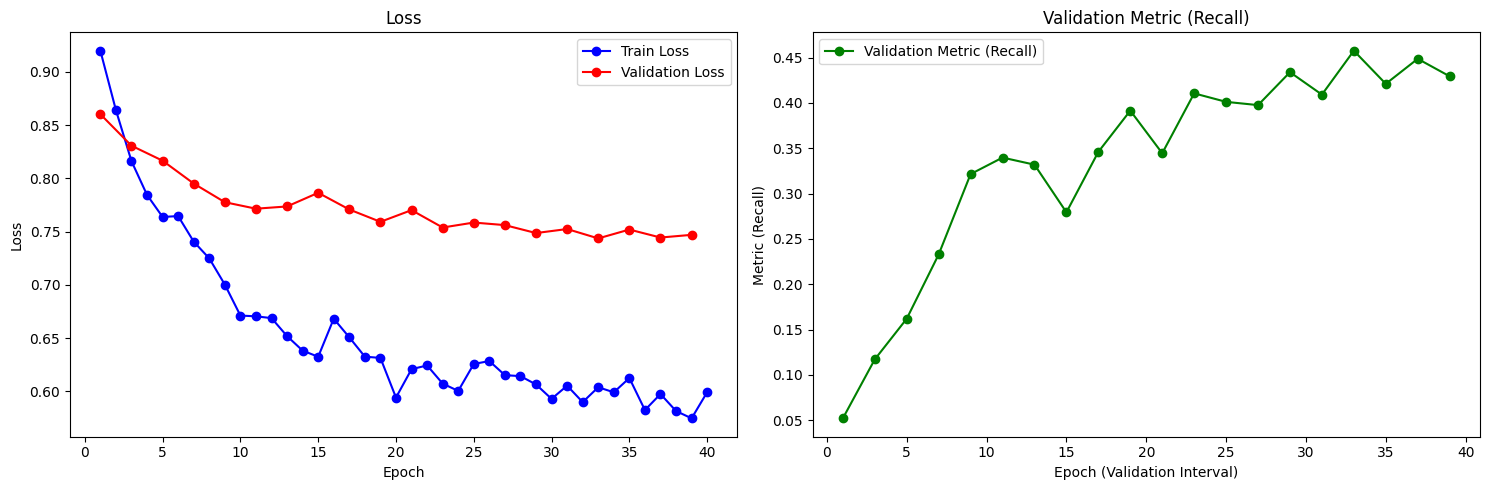

In [ ]:
epochs = range(1, len(epoch_loss_values) + 1)
val_epochs = epochs[::2] # validation loss는 val_interval=2 마다 계산됨

plt.figure(figsize=(15, 5)) # 그래프 가로 크기 약간 늘림

# Train Loss & Validation Loss 시각화 (subplot 1)
plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_loss_values, 'bo-', label='Train Loss')
plt.plot(val_epochs, val_loss_values, 'ro-', label='Validation Loss') # Validation loss 추가
plt.title('Loss') # 제목 변경
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Metric 시각화 (subplot 2 - 기존과 동일)
plt.subplot(1, 2, 2)
plt.plot(val_epochs, metric_values, 'go-', label='Validation Metric (Recall)') # validation metric 색상 변경 (녹색)
plt.title('Validation Metric (Recall)')
plt.xlabel('Epoch (Validation Interval)')
plt.ylabel('Metric (Recall)')
plt.legend()

plt.tight_layout()
plt.show()

## Test

In [ ]:
!pip install connected-components-3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 39.0 MB/s eta 0:00:00


In [ ]:
import json
import cc3d
from typing import List, Tuple

In [ ]:
# Constants for submission
BLOB_THRESHOLD = 500
CERTAINTY_THRESHOLD = 0.5
PATCH_SIZE = 96

# Load copick config and update static_root for test data
with open(copick_config_path) as f:
    copick_config = json.load(f)
copick_config['static_root'] = "/kaggle/input/czii-cryo-et-object-identification/test/static"
copick_config['overlay_root'] = ""

# Create a new config file for testing
copick_test_config_path = '/kaggle/working/copick_test.config'
with open(copick_test_config_path, 'w') as outfile:
    json.dump(copick_config, outfile)

# Initialize copick root for test data
root_test = copick.from_file(copick_test_config_path)

In [ ]:
# Re-use inference transforms from the example code, but apply to "image" only
inference_transforms = Compose([
    EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image"], axcodes="RAS")
])

# Mapping from class ID to particle name
id_to_name = {obj.label: obj.name for obj in root_test.pickable_objects if obj.is_particle}
classes = [obj.label for obj in root_test.pickable_objects if obj.is_particle]

# Post processing for converting model output to discrete values
post_pred = AsDiscrete(argmax=True, to_onehot=len(root_test.pickable_objects)+1)

# 모델 설정
# 이전에 학습한 모델 파라미터를 정의
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=len(root_test.pickable_objects)+1,
    channels=(48, 64, 80, 80),
    strides=(2, 2, 1),
    num_res_units=1,
).to(device)

# 이전에 학습한 모델 파라미터가 저장된 경로
model.load_state_dict(torch.load("/kaggle/working/best_metric_model.pth"))

# Set model to evaluation mode and use GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()
model.to(device)

# Create submission DataFrame
location_df = []

with torch.no_grad():
    for run in tqdm(root_test.runs):
        tomo = run.get_voxel_spacing(voxel_size).get_tomogram(tomo_type).numpy()

        # Split tomogram into patches
        tomo_patches, coordinates = extract_3d_patches_minimal_overlap([tomo], PATCH_SIZE)
        tomo_patched_data = [{"image": img} for img in tomo_patches]

        # Create dataset and apply inference transforms
        tomo_ds = Dataset(data=tomo_patched_data, transform=inference_transforms)
        tomo_loader = DataLoader(tomo_ds, batch_size=1, shuffle=False, num_workers=0)

        # Predict segmentation masks for each patch
        pred_masks = []
        for batch in tomo_loader:
            inputs = batch["image"].to(device)
            outputs = model(inputs)

            probs = torch.softmax(outputs[0], dim=0)
            thresh_probs = probs > CERTAINTY_THRESHOLD
            _, max_classes = thresh_probs.max(dim=0)

            pred_masks.append(max_classes.cpu().numpy())

        # Reconstruct the full segmentation mask from patches
        reconstructed_mask = reconstruct_array(pred_masks, coordinates, tomo.shape)

        # Find connected components and centroids for each class
        location = {}
        for c in classes:
            cc = cc3d.connected_components(reconstructed_mask == c)
            stats = cc3d.statistics(cc)
            zyx = stats['centroids'][1:] * 10.012444  # Voxel size correction
            zyx_large = zyx[stats['voxel_counts'][1:] > BLOB_THRESHOLD]
            xyz = np.ascontiguousarray(zyx_large[:, ::-1])
            location[id_to_name[c]] = xyz

        # Convert to DataFrame and append to the list
        df = dict_to_df(location, run.name)
        location_df.append(df)

# Concatenate all DataFrames and save to CSV
location_df = pd.concat(location_df)
location_df.insert(loc=0, column='id', value=np.arange(len(location_df)))
location_df.to_csv("submission.csv", index=False)

<ipython-input-30-e439886674ad>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/best_metric_model.pth"))
  0%|          |

In [ ]:
# 2. 평가 및 시각화 코드 추가

from scipy.optimize import linear_sum_assignment

### czii_helper.py

In [ ]:
from timeit import default_timer as timer
def time_to_str(t, mode='min'):
	if mode=='min':
		t  = int(t)/60
		hr = t//60
		min = t%60
		return '%2d hr %02d min'%(hr,min)

	elif mode=='sec':
		t   = int(t)
		min = t//60
		sec = t%60
		return '%2d min %02d sec'%(min,sec)

	else:
		raise NotImplementedError



class dotdict(dict):
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    def __getattr__(self, name):
        try:
            return self[name]
        except KeyError:
            raise AttributeError(name)

### dataset.py

In [ ]:
import pandas as pd
import numpy as np
import json
import zarr

PARTICLE= [
    {
        "name": "apo-ferritin",
        "difficulty": 'easy',
        "pdb_id": "4V1W",
        "label": 1,
        "color": [0, 255, 0, 0],
        "radius": 60,
        "map_threshold": 0.0418
    },
    {
        "name": "beta-amylase",
        "difficulty": 'ignore',
        "pdb_id": "1FA2",
        "label": 2,
        "color": [0, 0, 255, 255],
        "radius": 65,
        "map_threshold": 0.035
    },
    {
        "name": "beta-galactosidase",
        "difficulty": 'hard',
        "pdb_id": "6X1Q",
        "label": 3,
        "color": [0, 255, 0, 255],
        "radius": 90,
        "map_threshold": 0.0578
    },
    {
        "name": "ribosome",
        "difficulty": 'easy',
        "pdb_id": "6EK0",
        "label": 4,
        "color": [0, 0, 255, 0],
        "radius": 150,
        "map_threshold": 0.0374
    },
    {
        "name": "thyroglobulin",
        "difficulty": 'hard',
        "pdb_id": "6SCJ",
        "label": 5,
        "color": [0, 255, 255, 0],
        "radius": 130,
        "map_threshold": 0.0278
    },
    {
        "name": "virus-like-particle",
        "difficulty": 'easy',
        "pdb_id": "6N4V",
        "label": 6,
        "color": [0, 0, 0, 255],
        "radius": 135,
        "map_threshold": 0.201
    }
]

PARTICLE_COLOR=[[0,0,0]]+[
    PARTICLE[i]['color'][1:] for i in range(6)
]
PARTICLE_NAME=['none']+[
    PARTICLE[i]['name'] for i in range(6)
]

'''
(184, 630, 630)
(92, 315, 315)
(46, 158, 158)
'''

def read_one_data(id, static_dir):
    zarr_dir = f'{static_dir}/{id}/VoxelSpacing10.000'
    zarr_file = f'{zarr_dir}/denoised.zarr'
    zarr_data = zarr.open(zarr_file, mode='r')
    volume = zarr_data[0][:]
    max = volume.max()
    min = volume.min()
    volume = (volume - min) / (max - min)
    volume = volume.astype(np.float16)
    return volume


def read_one_truth(id, overlay_dir):
    location={}

    json_dir = f'{overlay_dir}/{id}/Picks'
    for p in PARTICLE_NAME[1:]:
        json_file = f'{json_dir}/{p}.json'

        with open(json_file, 'r') as f:
            json_data = json.load(f)

        num_point = len(json_data['points'])
        loc = np.array([list(json_data['points'][i]['location'].values()) for i in range(num_point)])
        location[p] = loc

    return location

In [ ]:
# 3. MODE, valid_dir, valid_id 설정
if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    MODE = 'submit'
else:
    MODE = 'local'

valid_dir ='/kaggle/input/czii-cryo-et-object-identification/train'
valid_id = ['TS_5_4']

# 4. do_one_eval, compute_lb 함수
def do_one_eval(truth, predict, threshold):
    P=len(predict)
    T=len(truth)

    if P==0:
        hit=[[],[]]
        miss=np.arange(T).tolist()
        fp=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    if T==0:
        hit=[[],[]]
        fp=np.arange(P).tolist()
        miss=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    #---
    distance = predict.reshape(P,1,3)-truth.reshape(1,T,3)
    distance = distance**2
    distance = distance.sum(axis=2)
    distance = np.sqrt(distance)
    p_index, t_index = linear_sum_assignment(distance)

    valid = distance[p_index, t_index] <= threshold
    p_index = p_index[valid]
    t_index = t_index[valid]
    hit = [p_index.tolist(), t_index.tolist()]
    miss = np.arange(T)
    miss = miss[~np.isin(miss,t_index)].tolist()
    fp = np.arange(P)
    fp = fp[~np.isin(fp,p_index)].tolist()

    metric = [P,T,len(hit[0]),len(miss),len(fp)] #for lb metric F-beta copmutation
    return hit, fp, miss, metric


def compute_lb(submit_df, overlay_dir):
    valid_id = list(submit_df['experiment'].unique())
    print(valid_id)

    eval_df = []
    for id in valid_id:
        truth = read_one_truth(id, overlay_dir) #=f'{valid_dir}/overlay/ExperimentRuns')
        id_df = submit_df[submit_df['experiment'] == id]
        for p in PARTICLE:
            p = dotdict(p)
            print('\r', id, p.name, end='', flush=True)
            xyz_truth = truth[p.name]
            xyz_predict = id_df[id_df['particle_type'] == p.name][['x', 'y', 'z']].values
            hit, fp, miss, metric = do_one_eval(xyz_truth, xyz_predict, p.radius* 0.5)
            eval_df.append(dotdict(
                id=id, particle_type=p.name,
                P=metric[0], T=metric[1], hit=metric[2], miss=metric[3], fp=metric[4],
            ))
    print('')
    eval_df = pd.DataFrame(eval_df)
    gb = eval_df.groupby('particle_type').agg('sum').drop(columns=['id'])
    gb.loc[:, 'precision'] = gb['hit'] / gb['P']
    gb.loc[:, 'precision'] = gb['precision'].fillna(0)
    gb.loc[:, 'recall'] = gb['hit'] / gb['T']
    gb.loc[:, 'recall'] = gb['recall'].fillna(0)
    gb.loc[:, 'f-beta4'] = 17 * gb['precision'] * gb['recall'] / (16 * gb['precision'] + gb['recall'])
    gb.loc[:, 'f-beta4'] = gb['f-beta4'].fillna(0)

    gb = gb.sort_values('particle_type').reset_index(drop=False)
    # https://www.kaggle.com/competitions/czii-cryo-et-object-identification/discussion/544895
    gb.loc[:, 'weight'] = [1, 0, 2, 1, 2, 1]
    lb_score = (gb['f-beta4'] * gb['weight']).sum() / gb['weight'].sum()
    return gb, lb_score

['TS_5_4', 'TS_69_2', 'TS_6_4']
 TS_6_4 virus-like-particle
         particle_type    P    T  hit  miss   fp  precision    recall  \
0         apo-ferritin   78  139   45    94   33   0.576923  0.323741   
1         beta-amylase  122   31   12    19  110   0.098361  0.387097   
2   beta-galactosidase  330   40   26    14  304   0.078788  0.650000   
3             ribosome  219  142  113    29  106   0.515982  0.795775   
4        thyroglobulin  725   94   79    15  646   0.108966  0.840426   
5  virus-like-particle   91   30   28     2   63   0.307692  0.933333   

    f-beta4  weight  
0  0.332320       1  
1  0.330097       0  
2  0.455670       2  
3  0.771176       1  
4  0.602512       2  
5  0.833625       1  
lb_score: 0.5790694366095249

TS_5_4 apo-ferritin
	 num truth   : 46
	 num predict : 26
	 num hit  : 19
	 num fp   : 7
	 num miss : 27
TS_5_4 beta-amylase
	 num truth   : 10
	 num predict : 44
	 num hit  : 6
	 num fp   : 38
	 num miss : 4
TS_5_4 beta-galactosidase
	 num tru

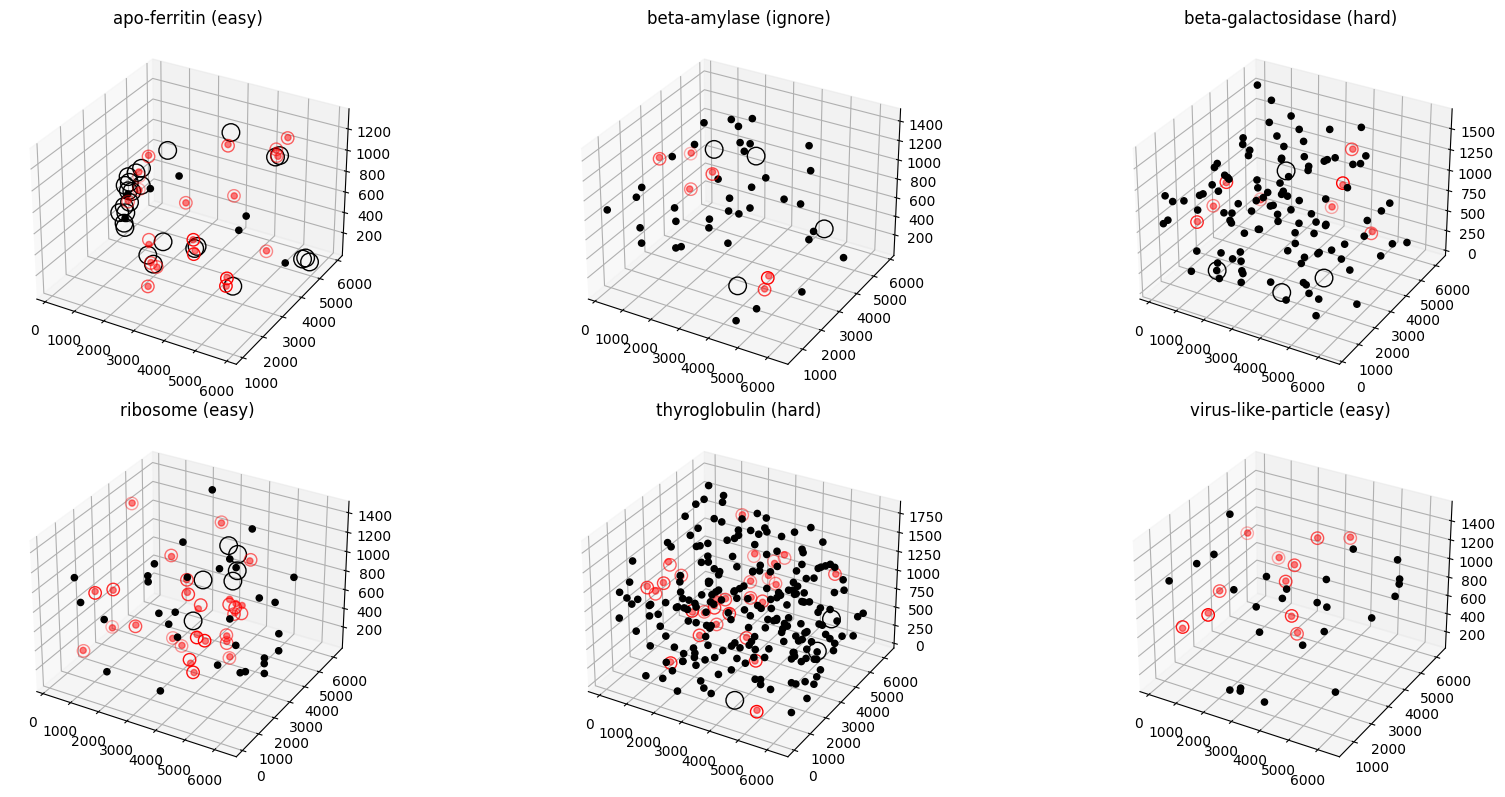

In [ ]:
# 5. 평가 및 시각화
#debug
if 1:
    if MODE=='local':
    #if 1:
        submit_df=pd.read_csv(
           'submission.csv'
            # '/kaggle/input/hengck-czii-cryo-et-weights-01/submission.csv'
        )
        gb, lb_score = compute_lb(submit_df, f'{valid_dir}/overlay/ExperimentRuns')
        print(gb)
        print('lb_score:',lb_score)
        print('')


        #show one ----------------------------------
        fig = plt.figure(figsize=(18, 8))

        id = valid_id[0]
        truth = read_one_truth(id,overlay_dir=f'{valid_dir}/overlay/ExperimentRuns')

        submit_df = submit_df[submit_df['experiment']==id]
        for p in PARTICLE:
            p = dotdict(p)
            xyz_truth = truth[p.name]
            xyz_predict = submit_df[submit_df['particle_type']==p.name][['x','y','z']].values
            hit, fp, miss, _ = do_one_eval(xyz_truth, xyz_predict, p.radius)
            print(id, p.name)
            print('\t num truth   :',len(xyz_truth) )
            print('\t num predict :',len(xyz_predict) )
            print('\t num hit  :',len(hit[0]) )
            print('\t num fp   :',len(fp) )
            print('\t num miss :',len(miss) )

            ax = fig.add_subplot(2, 3, p.label, projection='3d')
            if hit[0]:
                pt = xyz_predict[hit[0]]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=0.5, color='r')
                pt = xyz_truth[hit[1]]
                ax.scatter(pt[:,0], pt[:,1], pt[:,2], s=80, facecolors='none', edgecolors='r')
            if fp:
                pt = xyz_predict[fp]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=1, color='k')
            if miss:
                pt = xyz_truth[miss]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], s=160, alpha=1, facecolors='none', edgecolors='k')

            ax.set_title(f'{p.name} ({p.difficulty})')

        plt.tight_layout()
        plt.show()